# **Intoroduction**

The degradation that can occur to aircraft parts over the course of their lifetime directly impacts both their performance and reliability. In order to provide the necessary maintenance behavior, this machine learning research will be focused on providing a framework for predicting the aircraft's remaining usable life (RUL) based on the whole life cycle data. Using the NASA C-MAPSS data set is implemented and tested to determine the engine lifetime.

Tracking and predicting the progression of damage in aircraft engine turbo machinery has some roots in the work of Kurosaki. They estimate the efficiency and the flow rate deviation of the compressor and the turbine based on operational data, and utilize this information for fault detection purposes.

<div style="width:100%;text-align: center;"><img src="https://i.postimg.cc/ZqdZ56mW/turbo-jet-engine-diagram.jpg" width="500px" height="500px"></div>

An important requirement for the damage modeling process was the availability of a suitable system model that allows input variations of health related parameters and recording of the resulting output sensor measurements. The recently released C-MAPSS (Commercial Modular Aero- Propulsion System Simulation) meets these requirements and was chosen for this work.
C-MAPSS is a tool for simulating a realistic large commercial turbofan engine.

A layout showing various modules and their connections as modeled in the simulation.

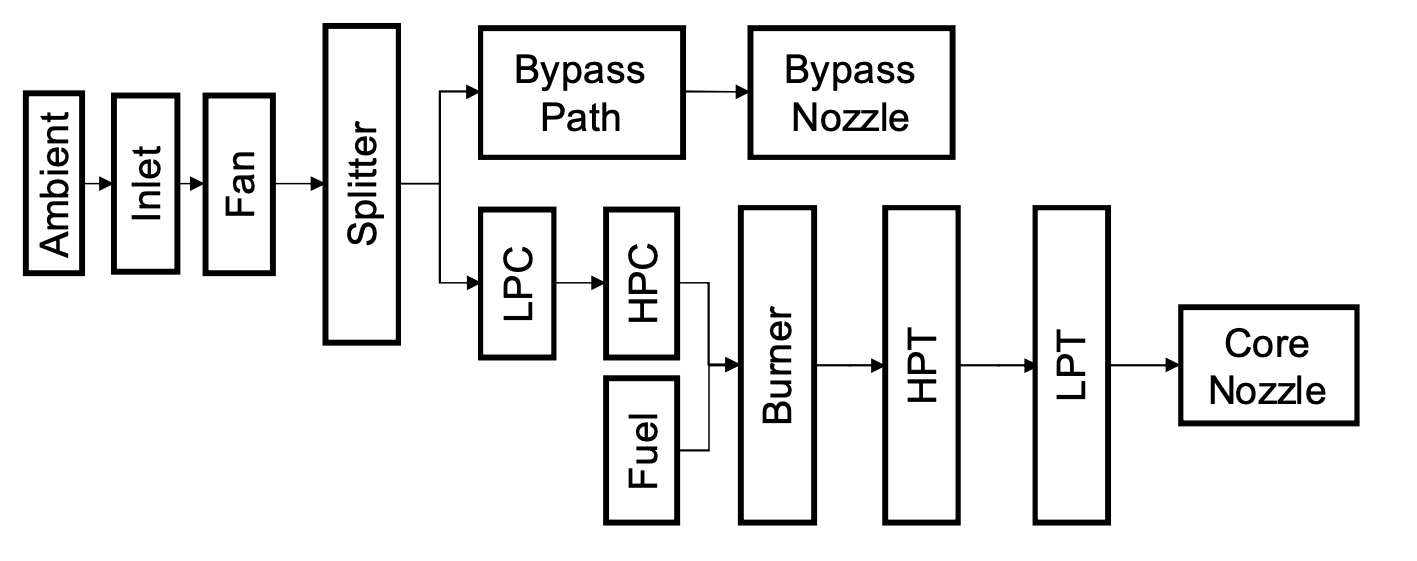

A low pressure compressor (LPC) and high pressure compressor (HPC) supply compressed high temperature, high pressure gases to the combustor. Low pressure turbine (LPT) can decelerate and pressurize air to improve the chemical energy conversion efficiency of aviation kerosene. High pressure turbines (HPT) generate mechanical energy by using high temperature and high pressure gas strike turbine blades. Low-pressure rotor (N1), high-pressure rotor (N2), and nozzle guarantee the combustion efficiency of the engine.

Our main focus will be on accurately recording low RUL values to prevent putting the engine at danger and forecasting the RUL of the turbofan engine while accounting for HPC failure.
Data analysis, data visualization and LSTM will all be covered in this notebook.

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
import math
import xgboost
import time
from tqdm import tqdm
import keras.models
import keras.layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import warnings
warnings.simplefilter('ignore')

In [ ]:
data_train = pd.read_csv("/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt",sep=" ",header=None)
data_test = pd.read_csv("/kaggle/input/nasa-cmaps/CMaps/test_FD001.txt",sep=" ",header=None)
data_RUL = pd.read_csv("/kaggle/input/nasa-cmaps/CMaps/RUL_FD001.txt",sep=" ",header=None)

train_copy = data_train
test_copy = data_test

In [ ]:
data_train

In [ ]:
data_test

In [ ]:
data_RUL

In [ ]:
data_train.drop(columns=[26,27],inplace=True)
data_test.drop(columns=[26,27],inplace=True)
data_RUL.drop(columns=[1],inplace=True)

In [ ]:
columns_train = ['unit_ID','cycles','setting_1','setting_2','setting_3','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
data_train.columns = columns_train
data_train.describe()

When we inspect the descriptive statistics of unit_ID we can see the dataset has a total of 20631 rows, unit numbers start at 1 and end at 100 as expected. What’s interesting, is that the mean and quantiles don’t align neatly with the descriptive statistics of a vector from 1–100, this can be explained due to each unit having different max cycles and thus a different number of rows. When inspecting the max cycles you can see the engine which operated the longest broke down after 362 cycles.

<div style="width:100%;text-align: center;"><img src="https://i.postimg.cc/Tw0sdPKy/units1.png" width="500px" height="500px"></div>

<div style="width:100%;text-align: center;"><img src="https://i.postimg.cc/3NwcdHGt/units2.png" width="500px" height="500px"></div>

In [ ]:
# Define a function to calculate the remaining useful life (RUL)
def add_rul(g):
    # Calculate the RUL as the difference between the maximum cycle value and the cycle value for each row
    g['RUL'] = max(g['cycles']) - g['cycles']
    return g

# Apply the add_rul function to the training data grouped by the unit ID
train = data_train.groupby('unit_ID').apply(add_rul)

In [ ]:
train.head()

Let us see the maximum time cycle of each unit

In [ ]:
cnt_train = train[["unit_ID", "cycles"]].groupby("unit_ID").max().sort_values(by="cycles", ascending=False)
cnt_ind = [str(i) for i in cnt_train.index.to_list()]
cnt_val = list(cnt_train.cycles.values)

plt.style.use("seaborn")
plt.figure(figsize=(12, 30))
sns.barplot(x=list(cnt_val), y=list(cnt_ind), palette='magma')
plt.xlabel('Number of Cycles')
plt.ylabel('Engine Id')
plt.title('Number of Cycles for Engines', fontweight='bold', fontsize=24, pad=15)

plt.show()

In [ ]:
plt.figure(figsize=(18, 9))
subset_stats = data_train.agg(['mean', 'std']).T[2:]
ax = sns.barplot(x=subset_stats.index, y="std", data=subset_stats, palette='magma')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel("Sensor")
ax.set_ylabel("Standard Deviation")
ax.set_title("Standard Deviation of Each Column", fontweight='bold', fontsize=24, pad=15)

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

NC with a standard deviation of 22.083, suggests that the values of this variable are quite spread out from the mean.

In [ ]:
train.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','setting_3','farB','epr'],inplace=True) 

In [ ]:
sns.heatmap(train.corr(),annot=True,cmap='Blues',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

Takes datalength and earlyrul as input and creates target RUL.

This function takes in two arguments, data_length and early_rul. It returns an array that represents the remaining useful life (RUL) for each cycle in the input data. If the early_rul_duration is less than or equal to 0, then the target variable is a reversed range of data_length-1 to 0.

In [ ]:
def process_targets(data_length, early_rul = None):
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

This function takes in input data and target data and processes them with a specified window length and shift size. The output_data is a numpy array with shape (num_batches, window_length, num_features). If target_data is not None, the function also outputs output_targets, a numpy array with shape (num_batches,) containing the target values for each batch.

In [ ]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

This function processes the test data for a single engine in preparation for making predictions using a trained model. It takes in the test data for a single engine (test_data_for_an_engine), the window_length and shift parameters that were used in preparing the training data, and the number of test windows (num_test_windows) that should be processed.

In [ ]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
  
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length= window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length= window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

The default option is to take only the last window of test data for each engine, which amounts to one window. However, if you set the number to a different value, that many windows from the last will be taken, and the final output will be the average of all the windows.

In [ ]:
test_data = pd.read_csv("/kaggle/input/nasa-cmaps/CMaps/test_FD001.txt", sep = "\s+", header = None,names=columns_train )
true_rul = pd.read_csv("/kaggle/input/nasa-cmaps/CMaps/RUL_FD001.txt", sep = '\s+', header = None)

window_length = 30
shift = 1
early_rul = 125           
processed_train_data = []
processed_train_targets = []
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped =['unit_ID','setting_1','setting_2','setting_3', 'T2', 'P2','P15','P30', 'epr',
                 'farB', 'Nf_dmd', 'PCNfR_dmd']

train_data_first_column = data_train ["unit_ID"]
test_data_first_column = test_data["unit_ID"]

Scale data for all engines

In [ ]:
scaler = StandardScaler()
train_data = scaler.fit_transform(data_train.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

It is important to process the training and test data separately since the number of engines in each set may differ.
Since we scale the entire dataset, we do not need to be concerned about the differing number of engines between the training and test sets.

**Training data process:**

In [ ]:
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Determine whether it is possible to extract training data with the specified window length.
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length= window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

**Test data process:**

In [ ]:
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Determine whether it is possible to extract test data with the specified window length.
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length=window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

In [ ]:
print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

The shape of processed_train_data is (17731, 30, 14), which means we have 17731 engines, each with 30 time steps and 14 sensor readings at each time step.
The shape of processed_train_targets is (17731,), which means we have the corresponding target RUL values for the 17731 training samples.
The shape of processed_test_data is (497, 30, 14), which means we have 497 test or engines, each with 30 time steps and 14 sensor readings at each time step.
The shape of true_rul is (100,), which means we have the true RUL values for 100 test engines.

In [ ]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

# **LSTM**

LSTM stands for long short-term memory networks, used in the field of Deep Learning. It is a variety of recurrent neural networks (RNNs) that are capable of learning long-term dependencies, especially in sequence prediction problems.

This function creates a compiled model using the Keras Sequential API with the following architecture:
LSTM layer with 128 units, input shape of (window_length, 14), returns sequences and uses the hyperbolic tangent activation function.
LSTM layer with 64 units, returns sequences and uses the hyperbolic tangent activation function.
LSTM layer with 32 units, uses the hyperbolic tangent activation function.
Dense layer with 96 units and Rectified Linear Unit (ReLU) activation function. Dense layer with 128 units and ReLU activation function. Dense layer with 1 unit. The loss function used is mean squared error, and the optimizer used is with a learning rate of 0.001.

In [ ]:
def create_compiled_model():
    model = Sequential([
        layers.LSTM(128, input_shape = (window_length, 14), return_sequences=True, activation = "tanh"),
        layers.LSTM(64, activation = "tanh", return_sequences = True),
        layers.LSTM(32, activation = "tanh"),
        layers.Dense(96, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

Scheduler is a function that adjusts the learning rate during the training process, with the goal of improving the model's performance.
By adjusting the learning rate based on the epoch number, the scheduler can help the model converge more quickly and accurately.

In [ ]:
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 10,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 128, verbose = 2)

In [ ]:
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 10,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 128, verbose = 2)

Measure the difference between predicted and actual values.
RMSE = sqrt(1/n * Σ(actual_i - predicted_i)^2)

In [ ]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

To compute the RMSE, we consider only the last example of each engine.

In [ ]:
tf.keras.models.save_model(model, "FD001_LSTM_piecewise_RMSE_"+ str(np.round(RMSE, 4)) + ".h5")

indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

A value of 15.30 indicates that the average deviation of the predictions from the actual values is around 15.30

rul_true and rul_pred should be 1D numpy arrays

In [ ]:
def compute_s_score(rul_true, rul_pred):
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

It is a measure of the difference between the actual and predicted RUL values normalized by the standard deviation of the RUL.
A higher S-score indicates a better prediction performance.
In general, an S-score of 458.1 indicates a good performance of the prediction model.

In [ ]:
plt.plot(true_rul, label = "True RUL", color = "orange")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()